## Notes for Mercari Price Suggestion Challenge

Examples and helpers for the presentation:

https://docs.google.com/presentation/d/1AtvVds00Sfd8UJmO_ySKcN67tAwreDj3UA9MGJxZ1SA/edit?usp=sharing


In [33]:
%matplotlib inline
import pylab as plt
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.1f}'.format

### Data

`train_id` or `test_id` - integer, enumerated (no apparent data leakage)

`name` 			        - string

`item_condition_id`	    - integer levels (1-5, where 1 is new and 5 is poor)

`category_name`	        - string (with levels, e.g. Women/Tops & Blouses/Blouse)

`brand_name`		    - string, if no brand name left empty

`price`				    - integer

`shipping` 			    - binary, 1 if the seller pays for it (free shipping), 0 otherwise

`item_description`      - string, where lack of description is marked as "No description yet"

In [34]:
mercari = pd.read_table('~/Downloads/train.tsv')
mercari.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,64.0,0,Size small but straps slightly shortened to fi...
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,6.0,1,You get three pairs of Sophie cheer shorts siz...
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,19.0,0,Girls Size small Plus green. Three shorts total.
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,8.0,0,I realized his pants are on backwards after th...


In [48]:
mercari.isnull().sum()[mercari.isnull().sum()>0]

category_name         6327
brand_name          632682
item_description         4
dtype: int64

In [47]:
np.round(mercari.describe(),2)

,train_id,item_condition_id,price,shipping
count,1482535.0,1482535.0,1482535.0,1482535.0
mean,741267.0,1.9,26.7,0.5
std,427971.1,0.9,38.6,0.5
min,0.0,1.0,0.0,0.0
25%,370633.5,1.0,10.0,0.0
50%,741267.0,2.0,17.0,0.0
75%,1111900.5,3.0,29.0,1.0
max,1482534.0,5.0,2009.0,1.0


The price seems strongly left-skewed, with 75% or more of prices below 30 and the maximum price is 2009. Seems reasonable to take a $\log(p+1)$.

The minimum price is 0.

#### Wait, what? $0 price?

In [37]:
zero = mercari.loc[mercari['price'] == 0]
zero.head(10)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1325,1325,Alabama Crimson Tide Quality Lanyard,1,Sports & Outdoors/Fan Shop/NCAA,NaN,0.0,1,TOP QUALITY THICK LANYARD Reversible sides wit...
2544,2544,Levi leggings,3,"Women/Jeans/Slim, Skinny",Levi's®,0.0,0,Light wash. Hardly worn. Size 24 but fits like...
2712,2712,Simple Red Lace Lingerie Top,3,Women/Underwear/G-Strings & Thongs,NaN,0.0,0,"Very simple but cute, a little form fitting as..."
3576,3576,Turquoise 15 Pc Makeup Brush Set,1,Beauty/Tools & Accessories/Makeup Brushes & Tools,NaN,0.0,1,1 left!
3761,3761,Girls size 7/8,3,Kids/Girls (4+)/Tops & T-Shirts,NaN,0.0,1,5 pair gap jean excellent used condition 3 chi...
5237,5237,Nursing Bra,3,Women/Underwear/Bras,Motherhood Maternity,0.0,0,Used a few times but was not able to nurse
6175,6175,"Multi Listing Bundled Package, Thanks",2,Electronics/Media/DVD,NaN,0.0,1,1)Large Collection of Full Length Strawberry S...
7116,7116,Nike Dri-Fit High Power Speed Tights,1,"Women/Athletic Apparel/Pants, Tights, Leggings",Nike,0.0,1,"Bought at Nike store in New York, Brand New, N..."
7622,7622,Hands free earpiece,1,Electronics/Cell Phones & Accessories/Headsets,NaN,0.0,0,Wireless Bluetooth hands free used with Samsun...
10812,10812,Vampire candy bowl,1,Home/Seasonal Décor/Halloween,NaN,0.0,0,New good condition for halloween


Ok, there are some anomalies. 

Let's look at the relation of price to other variables.

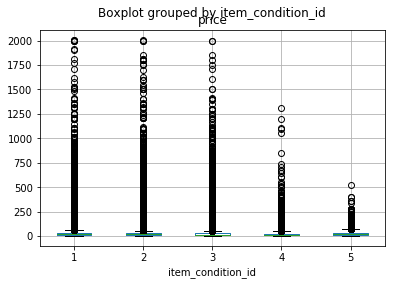

In [53]:
mercari.boxplot('price', by='item_condition_id')

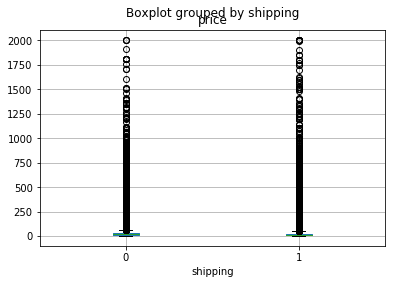

In [54]:
mercari.boxplot('price', by='shipping')

Let's take $\log$ of the price

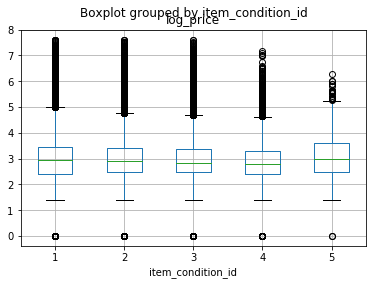

In [51]:
mercari['log_price'] = np.log(mercari['price'] + 1)
mercari.boxplot('log_price', by='item_condition_id')

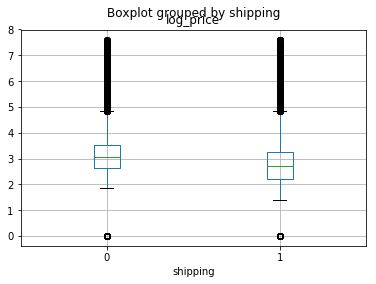

In [52]:
mercari.boxplot('log_price', by='shipping')

It seems that neither condition nor shipping have a strong individual impact on the price. 

More explorations of the data:
- https://www.kaggle.com/huguera/mercari-data-analysis/notebook
- https://rpubs.com/slazien/mercari_eda
- https://www.kaggle.com/jparajuli/mercari-price-suggestion-preliminary-analysis/notebook

### Evaluation

The evaluation method for the challenge was Root Mean Squared Logarithmic Error (RMSLE).

This section is an example comparison of Root Mean Squared Error and Root Mean Squared Logarithmic Error,
on sample data. 
Feel free to play around to get a better intuition!

In [55]:
# Sampling data
def sample_data(scale, spread, n_samples, slope):
    x = np.random.random(n_samples) * scale
    y = slope * x + 1 + np.random.random(n_samples) * spread
    obs = y
    pred = slope * x + spread / 2 + 1
    return x, y, obs, pred

# Plotting the data sample
def plot_sample(x, y, obs, pred):
    plt.plot(x, pred, '-', color='#8f4898')
    for idx in range(len(obs)):
        plt.plot([x[idx], x[idx]], [pred[idx], obs[idx]], '#D7907B')
    plt.plot(x, y, 'o', color='#531CB3')

$\large RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( p_i - a_i \right)^2}$

$\large RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(p_i+1) - \log(a_i+1) \right)^2}$

In [ ]:
def RMSE(pred, obs): 
    return np.sqrt(np.cumsum((pred - obs) ** 2) / (np.arange(len(pred)) + 1))
    
def RMSLE(pred, obs):
    return np.sqrt(np.cumsum((np.log(pred + 1) - np.log(obs + 1)) ** 2) / (np.arange(len(pred)) + 1))

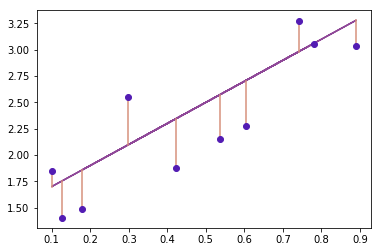

In [53]:
# Small sample of relatively small data
x, y, obs, pred = sample_data(1, 1, 10, 2)
plot_sample(x, y, obs, pred)

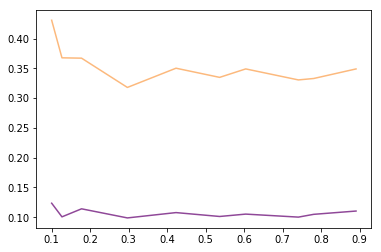

In [54]:
# If both predicted and actual values are small, RMSE and RMSLE are relatively close
plt.plot(sorted(x), RMSLE(pred, obs), color="#8f4898")
plt.plot(sorted(x), RMSE(pred, obs), color='#FCB97D')

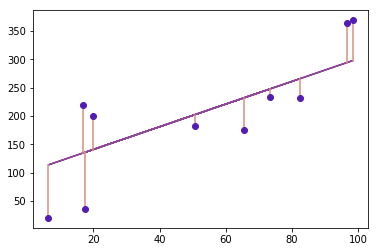

In [55]:
# Small sample of relatively big data
x, y, obs, pred = sample_data(100, 200, 10, 2)
plot_sample(x, y, obs, pred)

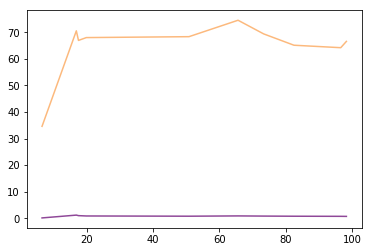

In [56]:
# If predicted and/or actual values are big, the RMSE becomes much bigger and RMSLE is negligible
plt.plot(sorted(x), RMSLE(pred, obs), color="#8f4898")
plt.plot(sorted(x), RMSE(pred, obs), color='#FCB97D')

## Concepts

Various concepts encountered in the winning solutions.

### Linear regression
A simple loss function might be based on the sum of squared residuals.

$\large L = \sum( p_i - a_i )^2$

### Ridge regression

Adding a squared coefficient to increase the penalty in the loss function, helps with avoiding overfitting. Reduces the $\beta$, but not necessarily to 0. Highly sensitive to outliers.

$\large L = \sum( p_i - a_i )^2 + \lambda\sum\beta^2$


### Lasso regression

Adding a coefficient to increase the penalty in the loss function, helps with avoiding overfitting. Reduces the $\beta$ to 0, which might result in fewer features in the resulting model.

$\large L = \sum( p_i - a_i )^2 + \lambda\sum| \beta |$

## Resources

#### While working on this presentation, I used numerous resources:

##### Ridge and lasso regression
    - [Practical machine learning: Ridge Regression vs. Lasso](https://hackernoon.com/practical-machine-learning-ridge-regression-vs-lasso-a00326371ece)
    - [Modern regression 1: Ridge regression](http://www.stat.cmu.edu/~ryantibs/datamining/lectures/16-modr1.pdf)
    
#### Gradient boosting
    - [A Kaggle master explains gradient boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)
    - [What is Light GBM?](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)
    - [Gradient Boosting explained [demonstration]](https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
    - [Gradient Boosting Interactive Playground](https://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)
    - [Light GBM features - Microsoft](https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst)
    
#### Feature extraction
    - [scikit learn - 4.2 Feature extraction](http://scikit-learn.org/stable/modules/feature_extraction.html)
    - [Text Learning with scikit learn](https://napitupulu-jon.appspot.com/posts/text-learning-ud120.html)

#### I also encountered some resources I didn't have the time to explore in depth:

    - [Lecture notes on ridge regression](https://arxiv.org/pdf/1509.09169.pdf)
    - [A comprehensive beginners guide for Linear, Ridge and Lasso Regression](https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/)
    - [Generalized Linear Models](http://scikit-learn.org/stable/modules/linear_model.html)
    - [A Beginner's Guide To Understanding Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/)
    - [Which algorithm takes the crown: Light GBM vs XGBOOST?](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)
    - [L1 vs L2 loss function](https://rishy.github.io/ml/2015/07/28/l1-vs-l2-loss/)
    - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
    - [How to Prepare Text Data for Machine Learning with scikit-learn](https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/)
    - [Machine Learning: Working With Stop Words, Stemming, and Spam](https://www.codeschool.com/blog/2016/03/25/machine-learning-working-with-stop-words-stemming-and-spam/)
    - [Working with text](https://de.dariah.eu/tatom/working_with_text.html)
    - [Sparse One Hidden Layer MLPs](https://www.elen.ucl.ac.be/Proceedings/esann/esannpdf/es2014-95.pdf)
    - [Ad Click Prediction: a View from the Trenches](http://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf)
    - [Factorization Machines with Follow-The-Regularized-Leader for CTR prediction in Display Advertising](http://wnzhang.net/share/rtb-papers/fm-ftrl.pdf)

#### And used some images:
    - [Supply and demand curve](https://epthinktank.eu/2016/02/09/secular-stagnation-and-the-euro-area/supply-and-demand-curve/)
    - [Gradient Boosting](https://sebastianraschka.com/faq/docs/bagging-boosting-rf.html)
    - [n-grams](http://recognize-speech.com/language-model/n-gram-model/comparison)